The purpose of this notebook is to test whether adding addition features of the number of max consecutive y peaks and "perc_in_ladder"(need to say better) helps MokaPot to score more PSMs at or below a certain cuttoff. 

In [4]:
import os
import mokapot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
sys.path
import data_loader as dl
import scipy.stats as stats

The purpose of this function is to clean up the original 'before' data so that we are not counting decoys or duplicate scans. AutoRT will not accept "U"s in the peptide sequence, so we are removing one scan from our data set that has this in it. 

In [5]:
def filter_data(df, prob_column):
     #drop decoys
    df = df[df["decoy"]== False]
    #sort by qvalue
    df = df.sort_values(prob_column)
    #Drop duplicates
    df = df.drop_duplicates(subset=["scan"], keep="first") #keep highest scoring
    
    df = df.loc[~(df["Peptide"].str.contains("U"))] #removing the U

    return df

This gives us the before data. It will not be run through MokaPot. It's purpose is to give us the ability to count how many PSMs originally are at or under a specific cutoff and compare that to the number we get after we run the data through MokaPot. 

In [6]:
def get_PreMokaPot_data(file):
    data = dl.clean_metamorph(file)
    data = filter_data(data,'QValue')
    return data

This reads in and cleans the data that will be run through MokaPot. MetaMorphues has a special output file that is formatted to be able to run through MokaPot.

In [7]:
def get_data_for_MokaPot(file):
    df_2 = dl.get_pin_file(file)
    df_2 = df_2.iloc[1: :]
    df_2 = df_2.drop_duplicates(subset=["ScanNr"], keep="first")
    
    df_2 = df_2.loc[~(df_2["Peptide"].str.contains("U"))] #removing the U
    
    return df_2

This function gives us the absolute difference between the actual retention time and the predicted retention time. *must be the absolute vaule, we do not want negative numbers. 

In [8]:
def calculate_diff(row):
    num = row['y'] - row['y_pred']
    if num < 0:
        num = num * (-1)
    return num

MetaMorpheus gives an output file that is specifically formatted for MokaPot. However, this file does not have q values, which we need to compare the before and after data. However, once the decoys are dropped from both files, the regular before file and the specailly formatted file contain the same scan numbers.
The before file is used to compute the number of max consecutive y peaks and "perc_in_ladder". These columns are then taken and then added to the specially formatted file. 

Here we read in the speically formatted file and the file that has the additional feature columns in it. Decoys are dropped from both of them, giving us the same number of scans in both file. We splice out the scan, max_consecutive_y, and "perc_in_ladder" columns. These columns are then joined with the formatted file based on their scan numbers. We can use this file to run through MokaPot and compare if the extra feature columns help MokaPot to score more PSMs below our cutoff. 

In [9]:
def get_peaks_data(file):

    data = pd.read_csv("peaks_files/" + file + "_peaks_data.csv", low_memory=False)
    
    #Removing the U to match the data coming from AutoRT
    data = data.loc[~(data["peptide"].str.contains("U"))] #removing the U
    
    data.loc[(data["peptide"].str.contains("U"))] #DELETE debugging here.  
    
    #Change the ladder column tye to float 
    data = data.astype({"perc_in_ladder": float})
    
    #sort based on the probability column
    data = data.sort_values('QValue')
    #drop duplicate scans
    data = data.drop_duplicates(subset=["scan"], keep="first") #keep highest scoring
    
    data = data.rename(columns = {"scan": "ScanNr"})
    data = data.filter(['ScanNr', 'max_consecutive_y', 'max_consecutive_b', 'perc_in_ladder'])
    data = data.set_index("ScanNr")
    
    #setting up the data from the pin file
    df_2 = dl.get_pin_file(file)
    df_2 = df_2.iloc[1: :]
    df_2 = df_2.loc[~(df_2["Peptide"].str.contains("U"))] #removing the U
    df_2 = df_2.astype({"ScanNr": int})
    df_2 = df_2.drop_duplicates(subset=["ScanNr"], keep="first")
    df_2 = df_2.set_index("ScanNr")
    
    
    joined_df = df_2.join(data, how = "outer")
    joined_df.reset_index(inplace=True)
    
    return joined_df
    

Here we read in the speically formatted file and the file that has the additional feature columns in it. Decoys are dropped from both of them, giving us the same number of scans in both file. We splice out the scan, and difference columns. These columns are then joined with the formatted file based on their scan numbers. We can use this file to run through MokaPot and compare if the extra feature columns help MokaPot to score more PSMs below our cutoff.

In [10]:
#Retriving and formatting the df that has the retention time info in it. Also doing the math to get 
#the difference colum

def retrive_RT_df(file):
    
    file_path = "predicted_data/" + file + "_predicted/test.tsv"
    
    data = pd.read_csv(file_path, sep = "\t", low_memory=False )    
    
    #sort based on the probability column
    data = data.sort_values('QValue')
    #drop duplicate scans
    data = data.drop_duplicates(subset=["scan"], keep="first") #keep highest scoring
    #changing the type
    data = data.astype({'y_pred': float})
    
    #calculating the difference column
    data['difference'] = data.apply(calculate_diff, axis = 1)
    
    data = data.rename(columns = {"scan": "ScanNr"})
    data = data.filter(['ScanNr', 'difference'])
    data = data.set_index("ScanNr")
    return data


In [11]:
def get_retentionTime_data(file):

    data = retrive_RT_df(file)
    
    #setting up the data from the pin file
    df_2 = dl.get_pin_file(file)
    df_2 = df_2.iloc[1: :]
    df_2 = df_2.astype({"ScanNr": int})
    df_2 = df_2.drop_duplicates(subset=["ScanNr"], keep="first")
    df_2 = df_2.loc[~(df_2["Peptide"].str.contains("U"))] #removing the U
    df_2 = df_2.set_index("ScanNr")
    
    
    joined_df = df_2.join(data, how = "outer")
    joined_df.reset_index(inplace=True)
    
    return joined_df

Taking the dataframe that has the peaks features added on and joining the additional retention time differnce column onto it. Returning the joined dataframe

In [12]:
def get_all_features_data(peaksData, RTdata):
    RTdata = RTdata.filter(['ScanNr', 'difference'])
    RTdata = RTdata.set_index("ScanNr")
    RTdata = RTdata.astype({'difference': float})
    
    peaksData = peaksData.set_index("ScanNr")
    peaksData = peaksData.astype({'perc_in_ladder': float})
    
    joined_df = peaksData.join(RTdata, how = "outer")
    joined_df.reset_index(inplace=True)
    
    return joined_df
   
    

In [2]:
#Read all the files into a list here
file_names = ["2ng_rep1", "2ng_rep2", "2ng_rep3", "2ng_rep4", "2ng_rep5", "2ng_rep6", 
              "0.2ng_rep1", "0.2ng_rep2", "0.2ng_rep3", "0.2ng_rep4", "0.2ng_rep5", "0.2ng_rep6"]

In order to tell if the new added features are helping MokaPot to score the PSMs higher, we run the program a certain number of times and look at the average scores.
We read in the data for the pin file, the regular data, and the data that has the added features. Because MokaPot gives an output file that is already formatted for MokaPot, we have to splice out the extra columns and joing them with the pin file.

In [3]:
limit = 25
file_number = 0
all_results = pd.DataFrame()


for file in file_names:
    file_number +=1
    rounds = 0
    print("running " + file)
    
    no_addedFeats_list = []
    #peaks_feature_list = []
    #RT_feature_list = []
    all_features_list = []
    
    #original_MM = get_PreMokaPot_data('2ng_rep1')
    regular_df = get_data_for_MokaPot(file)
    peaks_df = get_peaks_data(file)
    RT_df = get_retentionTime_data(file)
    all_feats_df = get_all_features_data(peaks_df, RT_df)


    while rounds < limit:

        #regular data, no additional features
        mm_for_MP = mokapot.read_pin(regular_df) 
        regular_results, models = mokapot.brew(mm_for_MP)

        #just the peaks features
#         mm_peaksFeat_MP = mokapot.read_pin(peaks_df) 
#         peaksAdded_results, added_models = mokapot.brew(mm_peaksFeat_MP)

        #just the retention time feature
#         mm_RT_feat_MP = mokapot.read_pin(RT_df)
#         RTadded_results, models = mokapot.brew(mm_RT_feat_MP)

        #all the additional features
        all_features_MP = mokapot.read_pin(all_feats_df)
        allAdded_results, models = mokapot.brew(all_features_MP)


        no_addedFeats_list.append(len(regular_results.psms[regular_results.psms['mokapot q-value'] <= 0.01]))
        print("without added feat: " + str(len(regular_results.psms[regular_results.psms['mokapot q-value'] <= 0.01])))

#         peaks_feature_list.append(len(peaksAdded_results.psms[peaksAdded_results.psms['mokapot q-value'] <= 0.01]))
#         print("with peaks feat: " + str(len(peaksAdded_results.psms[peaksAdded_results.psms['mokapot q-value'] <= 0.01])))

#         RT_feature_list.append(len(RTadded_results.psms[RTadded_results.psms['mokapot q-value'] <= 0.01]))
#         print("with RT feat: " + str(len(RTadded_results.psms[RTadded_results.psms['mokapot q-value'] <= 0.01])))

        all_features_list.append(len(allAdded_results.psms[allAdded_results.psms['mokapot q-value'] <= 0.01]))
        print("with all added feat: " + str(len(allAdded_results.psms[allAdded_results.psms['mokapot q-value'] <= 0.01])))

        rounds+= 1
        print("finished round " + str(rounds))
    
    #adding the new results to the df with all the PSMs found
    all_results[file + " None"] = no_addedFeats_list
    all_results[file + " All"] = all_features_list

    

NameError: name 'pd' is not defined

Making the graph for the average number of PSMs at or under a 0.01 cutoff. Standard deviation is given as well.

In [ ]:
df = pd.DataFrame(list(zip(no_addedFeats_list, all_features_list)),
               columns =['No Features', 'All Features'])

This function helps us to put the error bars on the box plot

In [83]:
def label_diff(x1, x2, pval, column):
  # statistical annotation
    y, h, col = column.max() + 50, 2, 'k'
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    plt.text((x1+x2)*.5, y+h, pval, ha='center', va='bottom', color=col)  


In [66]:
#calculate the t-test and return the pvalue
from decimal import Decimal
def calc_pval(col1, col2):
    t_test = stats.ttest_ind(col1, col2)
    pval = '%.2E' % Decimal((t_test.pvalue))
    return pval

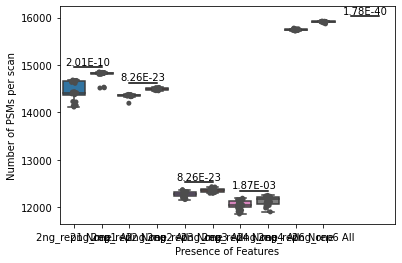

In [20]:
import seaborn as sns

# segment = all_results[['2ng_rep1 None', '2ng_rep1 All', '2ng_rep2 None', '2ng_rep2 All',
#        '2ng_rep3 None', '2ng_rep3 All', '2ng_rep4 None', '2ng_rep4 All',
#        '2ng_rep5 None', '2ng_rep5 All', '2ng_rep6 None', '2ng_rep6 All']]

segment = all_results[['2ng_rep1 None', '2ng_rep1 All', '2ng_rep2 None', '2ng_rep2 All',
       '2ng_rep3 None', '2ng_rep3 All', '2ng_rep4 None', '2ng_rep4 All',
       '2ng_rep6 None', '2ng_rep6 All']]

features_plot = sns.boxplot(data=segment, showfliers=False)
features_plot = sns.stripplot(data=segment, jitter=True, color=".3")
features_plot.set(ylabel = "Number of PSMs per scan")
features_plot.set(xlabel = "Presence of Features")


pval = calc_pval(all_results["2ng_rep1 None"], all_results["2ng_rep1 All"])
label_diff(0,1, pval, "2ng_rep1 All")

pval = calc_pval(all_results["2ng_rep2 None"], all_results["2ng_rep2 All"])
label_diff(2,3, pval, "2ng_rep2 All")

calc_pval(all_results["2ng_rep3 None"], all_results["2ng_rep2 All"])
label_diff(4,5, pval, "2ng_rep3 All")

pval = calc_pval(all_results["2ng_rep4 None"], all_results["2ng_rep4 All"])
label_diff(6,7, pval, "2ng_rep4 All")

# pval = calc_pval(all_results["2ng_rep5 None"], all_results["2ng_rep5 All"])
# label_diff(8,9, pval, "2ng_rep5 All")

pval = calc_pval(all_results["2ng_rep6 None"], all_results["2ng_rep6 All"])
label_diff(10,11, pval, "2ng_rep6 All")


plt.show()

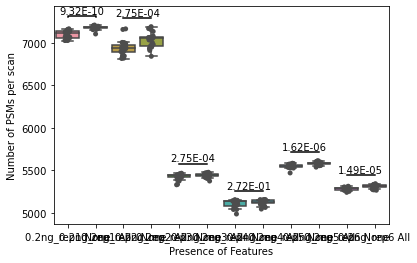

In [21]:
import seaborn as sns

point2ng_df = all_results[['0.2ng_rep1 None', '0.2ng_rep1 All', '0.2ng_rep2 None', 
                           '0.2ng_rep2 All', '0.2ng_rep3 None', '0.2ng_rep3 All', 
                           '0.2ng_rep4 None', '0.2ng_rep4 All', '0.2ng_rep5 None', 
                           '0.2ng_rep5 All', '0.2ng_rep6 None', '0.2ng_rep6 All']]
test = all_results[['0.2ng_rep4 None', '0.2ng_rep4 All']]

features_plot = sns.boxplot(data=point2ng_df, showfliers=False)
features_plot = sns.stripplot(data=point2ng_df, jitter=True, color=".3")
features_plot.set(ylabel = "Number of PSMs per scan")
features_plot.set(xlabel = "Presence of Features")


pval = calc_pval(all_results['0.2ng_rep1 None'], all_results['0.2ng_rep1 All'])
label_diff(0,1, pval, "0.2ng_rep1 All")

pval = calc_pval(all_results["0.2ng_rep2 None"], all_results["0.2ng_rep2 All"])
label_diff(2,3, pval, "0.2ng_rep2 All")

calc_pval(all_results["0.2ng_rep3 None"], all_results["0.2ng_rep3 All"])
label_diff(4,5, pval, "0.2ng_rep3 All")

pval = calc_pval(all_results["0.2ng_rep4 None"], all_results["0.2ng_rep4 All"])
label_diff(6,7, pval, "0.2ng_rep4 All")

pval = calc_pval(all_results["0.2ng_rep5 None"], all_results["0.2ng_rep5 All"])
label_diff(8,9, pval, "0.2ng_rep5 All")

pval = calc_pval(all_results["0.2ng_rep6 None"], all_results["0.2ng_rep6 All"])
label_diff(10,11, pval, "0.2ng_rep6 All")

plt.show()

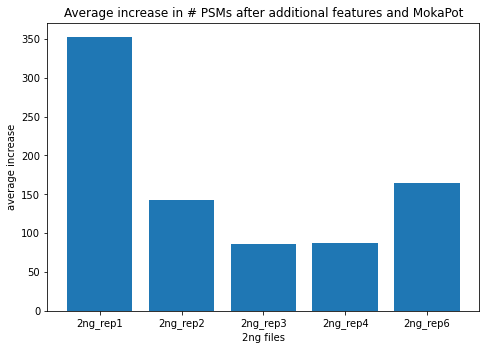

In [25]:
import statistics as stats

avg1 = stats.mean(all_results['2ng_rep1 All']) - stats.mean(all_results['2ng_rep1 None'])
avg2 = stats.mean(all_results['2ng_rep2 All']) - stats.mean(all_results['2ng_rep2 None'])
avg3 = stats.mean(all_results['2ng_rep3 All']) - stats.mean(all_results['2ng_rep3 None'])
avg4 = stats.mean(all_results['2ng_rep4 All']) - stats.mean(all_results['2ng_rep4 None'])
#avg5 = stats.mean(all_results['2ng_rep5 All']) - stats.mean(all_results['2ng_rep5 None'])
avg6 = stats.mean(all_results['2ng_rep6 All']) - stats.mean(all_results['2ng_rep6 None'])
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
increases = [avg1, avg2, avg3, avg4, avg6] #fix rep5
tools = ["2ng_rep1", "2ng_rep2", "2ng_rep3", "2ng_rep4",  "2ng_rep6"] #fix rep5
ax.bar(tools, increases)
plt.ylabel('average increase')
plt.xlabel('2ng files')
#plt.xlabel('Number of PSMs using native score and 0.01 cutoff')
plt.title('Average increase in # PSMs after additional features and MokaPot')
plt.show()